<a href="https://colab.research.google.com/github/vatsmanu728/National-e-Governance-Division/blob/main/Openforge_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder

# --------------------
# Load data
# --------------------
sheet_id = "15hQxQCelrIhxrzfqXSa1mCM6suCt9E5Bf85LbqqizcA"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# --------------------
# Preprocessing
# --------------------
# Encode categorical variables
cat_cols = ["Project", "Tech/NonTech", "Nature", "Category", "Priority", "Status ID"]
df_encoded = pd.get_dummies(df, columns=cat_cols)

# Define features and target
X = df_encoded.drop(columns=["Emp Name", "AID", "Task"])
y_raw = df["Emp Name"]

# Encode target labels (consistent)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# --------------------
# Handle singleton employees (only 1 record)
# --------------------
emp_counts = y_raw.value_counts()
singletons = emp_counts[emp_counts == 1].index

mask_singletons = y_raw.isin(singletons)

# Split train/test from the rest
X_train_main, X_test, y_train_main, y_test = train_test_split(
    X[~mask_singletons], y[~mask_singletons],
    test_size=0.2, random_state=42, stratify=y[~mask_singletons]
)

# Add singleton employees to training set
X_train = pd.concat([X_train_main, X[mask_singletons]])
y_train = np.concatenate([y_train_main, y[mask_singletons]])

# --------------------
# Train model
# --------------------
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

# --------------------
# Evaluation
# --------------------
y_pred = clf.predict(X_test)

print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))
print("Top-3 Accuracy:", top_k_accuracy_score(
    y_test,
    clf.predict_proba(X_test),
    k=3,
    labels=clf.classes_
))

# y_pred = clf.predict(X_test)

# print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))

# # Check for unseen classes in test
# unseen_in_train = set(y_test) - set(clf.classes_)
# if unseen_in_train:
#     print("⚠️ Warning: Some employees in test were never seen in training!")
#     print("Unseen classes (encoded IDs):", unseen_in_train)
#     print("Unseen employee names:", le.inverse_transform(list(unseen_in_train)))

# # Safe Top-k accuracy
# print("Top-3 Accuracy:", top_k_accuracy_score(
#     y_test,
#     clf.predict_proba(X_test),
#     k=3,
#     labels=le.classes_   # use full label set from encoder
# ))



Top-1 Accuracy: 0.2653061224489796
Top-3 Accuracy: 0.7551020408163265


In [21]:
# (Optional) Decode back employee names if you want
# print("Sample predictions:", le.inverse_transform(y_pred[:10]))


# --------------------
# Optional: decode predictions back to employee names
# --------------------
print("\nSample decoded predictions:")
print(le.inverse_transform(y_pred[:10]))   # first 10 predictions as names

print("\nSample decoded true labels:")
print(le.inverse_transform(y_test[:10]))   # first 10 true labels as names

# --------------------
# Create comparison DataFrame
# --------------------
pred_vs_true = pd.DataFrame({
    "True Employee": le.inverse_transform(y_test),
    "Predicted Employee": le.inverse_transform(y_pred)
})

# Add a correctness flag
pred_vs_true["Correct"] = pred_vs_true["True Employee"] == pred_vs_true["Predicted Employee"]

print("\nPrediction Comparison (first 20 rows):")
print(pred_vs_true.head(20))




Sample decoded predictions:
['Ankit kumar' 'Akash Dutta' 'Shrikant Bache' 'Ankit kumar' 'Ajit kumar'
 'Ankit kumar' 'P. Sujit Kumar Dora' 'Akash Dutta' 'chandrakanta panda'
 'Ashu Sharma']

Sample decoded true labels:
['Ankit kumar' 'Amit Kumar Das' 'Shrikant Bache' 'Shrikant Bache'
 'Ankit kumar' 'Ajit kumar' 'Ashu Sharma' 'Ashu Sharma' 'Amit Kumar Das'
 'Amit Kumar Das']

Prediction Comparison (first 20 rows):
         True Employee   Predicted Employee  Correct
0          Ankit kumar          Ankit kumar     True
1       Amit Kumar Das          Akash Dutta    False
2       Shrikant Bache       Shrikant Bache     True
3       Shrikant Bache          Ankit kumar    False
4          Ankit kumar           Ajit kumar    False
5           Ajit kumar          Ankit kumar    False
6          Ashu Sharma  P. Sujit Kumar Dora    False
7          Ashu Sharma          Akash Dutta    False
8       Amit Kumar Das   chandrakanta panda    False
9       Amit Kumar Das          Ashu Sharma    False


In [22]:
import numpy as np

# --------------------
# Create comparison DataFrame with Top-1 and Top-3
# --------------------
# Get prediction probabilities
y_prob = clf.predict_proba(X_test)

# For each sample, get the top 3 predicted employee IDs
top3_ids = np.argsort(y_prob, axis=1)[:, -3:][:, ::-1]  # sort descending

# Convert IDs back to names
top3_names = np.array([le.inverse_transform(row) for row in top3_ids])

# Build DataFrame
pred_vs_true = pd.DataFrame({
    "True Employee": le.inverse_transform(y_test),
    "Predicted Employee (Top-1)": le.inverse_transform(y_pred),
    "Top-3 Predictions": [list(row) for row in top3_names]
})

# Add correctness flags
pred_vs_true["Top1 Correct"] = pred_vs_true["True Employee"] == pred_vs_true["Predicted Employee (Top-1)"]
pred_vs_true["Top3 Correct"] = [
    true_emp in top3 for true_emp, top3 in zip(pred_vs_true["True Employee"], pred_vs_true["Top-3 Predictions"])
]

print("\nPrediction Comparison (first 20 rows):")
print(pred_vs_true.head(20))



Prediction Comparison (first 20 rows):
         True Employee Predicted Employee (Top-1)  \
0          Ankit kumar                Ankit kumar   
1       Amit Kumar Das                Akash Dutta   
2       Shrikant Bache             Shrikant Bache   
3       Shrikant Bache                Ankit kumar   
4          Ankit kumar                 Ajit kumar   
5           Ajit kumar                Ankit kumar   
6          Ashu Sharma        P. Sujit Kumar Dora   
7          Ashu Sharma                Akash Dutta   
8       Amit Kumar Das         chandrakanta panda   
9       Amit Kumar Das                Ashu Sharma   
10         Ashu Sharma             Shrikant Bache   
11  chandrakanta panda                Ashu Sharma   
12      Shrikant Bache              Hiranya Sarma   
13      Amit Kumar Das                Ashu Sharma   
14      Amit Kumar Das             Shrikant Bache   
15         Ashu Sharma                Ashu Sharma   
16         Ashu Sharma                Ashu Sharma   
17    


Per-Employee Accuracy Report:
         True Employee  Samples  Top1_Accuracy  Top3_Accuracy
5          Saket Soman        1       1.000000       1.000000
4  P. Sujit Kumar Dora        1       0.000000       1.000000
3          Ashu Sharma       23       0.347826       0.869565
1       Amit Kumar Das        8       0.000000       0.750000
2          Ankit kumar        3       0.333333       0.666667
6       Shrikant Bache        8       0.250000       0.625000
0           Ajit kumar        2       0.500000       0.500000
7   chandrakanta panda        3       0.000000       0.333333


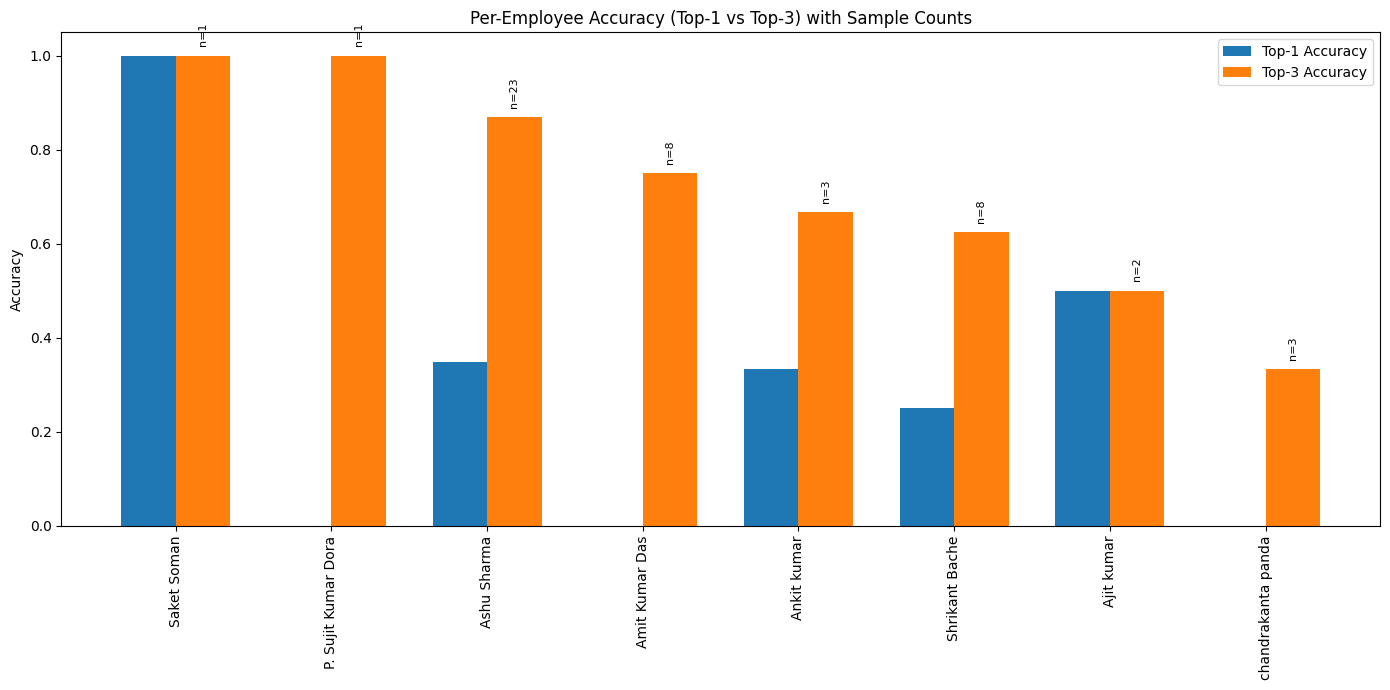

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------
# Per-employee accuracy report
# --------------------
employee_report = (
    pred_vs_true.groupby("True Employee")
    .agg(
        Samples=("True Employee", "count"),
        Top1_Accuracy=("Top1 Correct", "mean"),
        Top3_Accuracy=("Top3 Correct", "mean")
    )
    .reset_index()
    .sort_values(by="Top3_Accuracy", ascending=False)  # sort by Top-3 accuracy
)

print("\nPer-Employee Accuracy Report:")
print(employee_report)

# --------------------
# Plot: Top-1 vs Top-3 accuracy per employee
# --------------------
x = np.arange(len(employee_report))
width = 0.35  # width of each bar

plt.figure(figsize=(14, 7))
bars1 = plt.bar(x - width/2, employee_report["Top1_Accuracy"], width, label="Top-1 Accuracy")
bars2 = plt.bar(x + width/2, employee_report["Top3_Accuracy"], width, label="Top-3 Accuracy")

# Annotate sample counts above Top-3 bars
for i, (bar, count) in enumerate(zip(bars2, employee_report["Samples"])):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.02,   # slightly above the bar
        f"n={count}",
        ha="center", va="bottom", fontsize=8, rotation=90
    )

plt.xticks(x, employee_report["True Employee"], rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Employee Accuracy (Top-1 vs Top-3) with Sample Counts")
plt.legend()
plt.tight_layout()
plt.show()



Per-Employee Accuracy Report:
         True Employee  Samples  Top1_Accuracy  Top3_Accuracy
5          Saket Soman        1       1.000000       1.000000
4  P. Sujit Kumar Dora        1       0.000000       1.000000
3          Ashu Sharma       23       0.347826       0.869565
1       Amit Kumar Das        8       0.000000       0.750000
2          Ankit kumar        3       0.333333       0.666667
6       Shrikant Bache        8       0.250000       0.625000
0           Ajit kumar        2       0.500000       0.500000
7   chandrakanta panda        3       0.000000       0.333333


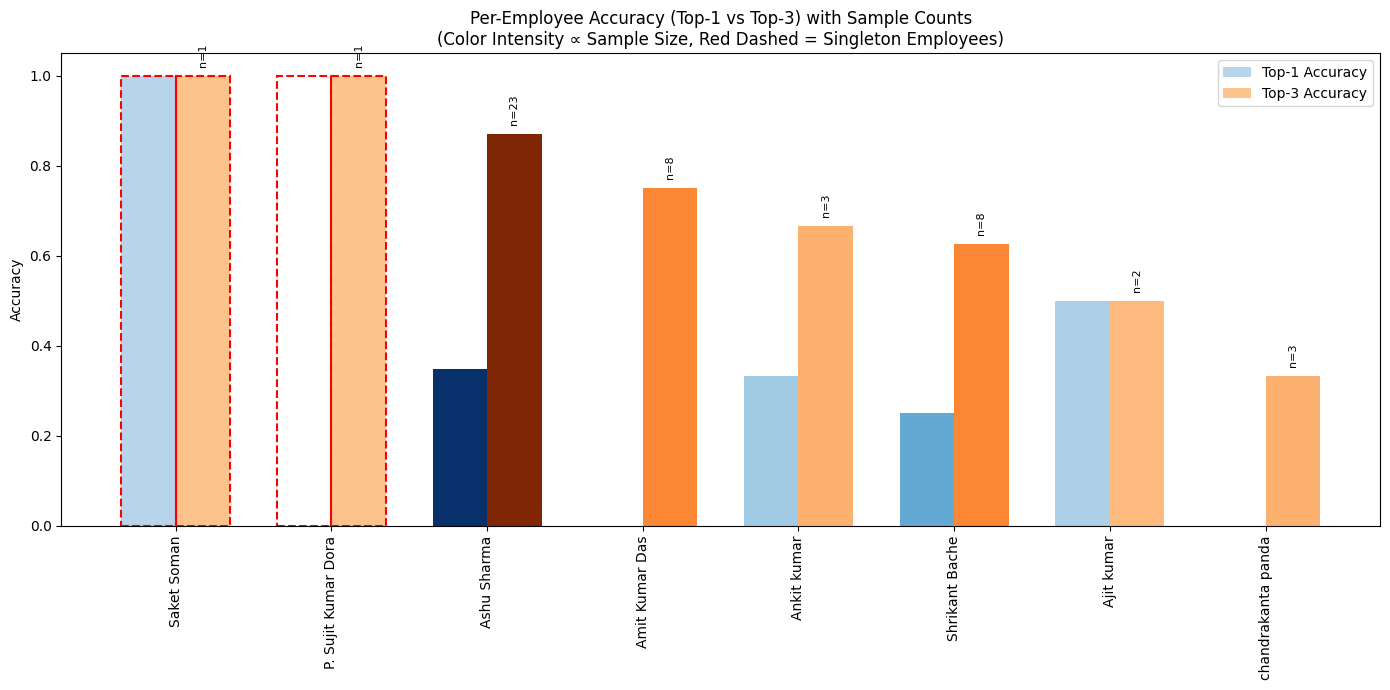

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --------------------
# Per-employee accuracy report
# --------------------
employee_report = (
    pred_vs_true.groupby("True Employee")
    .agg(
        Samples=("True Employee", "count"),
        Top1_Accuracy=("Top1 Correct", "mean"),
        Top3_Accuracy=("Top3 Correct", "mean")
    )
    .reset_index()
    .sort_values(by="Top3_Accuracy", ascending=False)  # sort by Top-3 accuracy
)

print("\nPer-Employee Accuracy Report:")
print(employee_report)

# --------------------
# Plot: Top-1 vs Top-3 accuracy per employee
# --------------------
x = np.arange(len(employee_report))
width = 0.35

# Normalize sample counts → color intensity
min_samples, max_samples = employee_report["Samples"].min(), employee_report["Samples"].max()
norm_samples = (employee_report["Samples"] - min_samples) / (max_samples - min_samples + 1e-9)

# Choose colormaps (blue for Top-1, green for Top-3)
cmap1 = cm.Blues
cmap2 = cm.Oranges

plt.figure(figsize=(14, 7))

bars1 = []
bars2 = []
for i, (top1, top3, count, norm) in enumerate(zip(
    employee_report["Top1_Accuracy"],
    employee_report["Top3_Accuracy"],
    employee_report["Samples"],
    norm_samples
)):
    color1 = cmap1(0.3 + 0.7*norm)  # darker if more samples
    color2 = cmap2(0.3 + 0.7*norm)

    # Top-1 bar
    bar1 = plt.bar(x[i] - width/2, top1, width, color=color1, label="Top-1 Accuracy" if i==0 else "")
    # Top-3 bar
    bar2 = plt.bar(x[i] + width/2, top3, width, color=color2, label="Top-3 Accuracy" if i==0 else "")

    bars1.append(bar1)
    bars2.append(bar2)

    # Annotate sample counts above Top-3 bars
    plt.text(
        bar2[0].get_x() + bar2[0].get_width()/2,
        bar2[0].get_height() + 0.02,
        f"n={count}",
        ha="center", va="bottom", fontsize=8, rotation=90
    )

    # 🔴 Highlight employees with only 1 sample
    if count == 1:
        for b in (bar1, bar2):
            plt.gca().add_patch(plt.Rectangle(
                (b[0].get_x(), 0),
                b[0].get_width(),
                1.0,
                fill=False, edgecolor="red", linewidth=1.5, linestyle="--"
            ))

plt.xticks(x, employee_report["True Employee"], rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Employee Accuracy (Top-1 vs Top-3) with Sample Counts\n(Color Intensity ∝ Sample Size, Red Dashed = Singleton Employees)")
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
import pandas as pd

# Get feature importances
importances = clf.feature_importances_

# Put into a DataFrame
feat_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_importances.head(15))  # top 15 features


                           Feature  Importance
0          Weights\n(Story Points)    0.147379
28                 Priority_Medium    0.071633
23                  Category_UI/UX    0.065224
11    Category_Feature/Enhancement    0.062741
26                   Priority_High    0.060715
14  Category_Monitoring/Operations    0.055408
27                    Priority_Low    0.054303
13     Category_Meeting/Discussion    0.046450
9      Category_Deployment/Release    0.045519
16      Category_New Product / POC    0.039557
6                    Nature_Simple    0.035232
18       Category_Refactor/Cleanup    0.034881
2             Tech/NonTech_NonTech    0.032537
3                Tech/NonTech_Tech    0.030305
5              Nature_Intermediate    0.028647


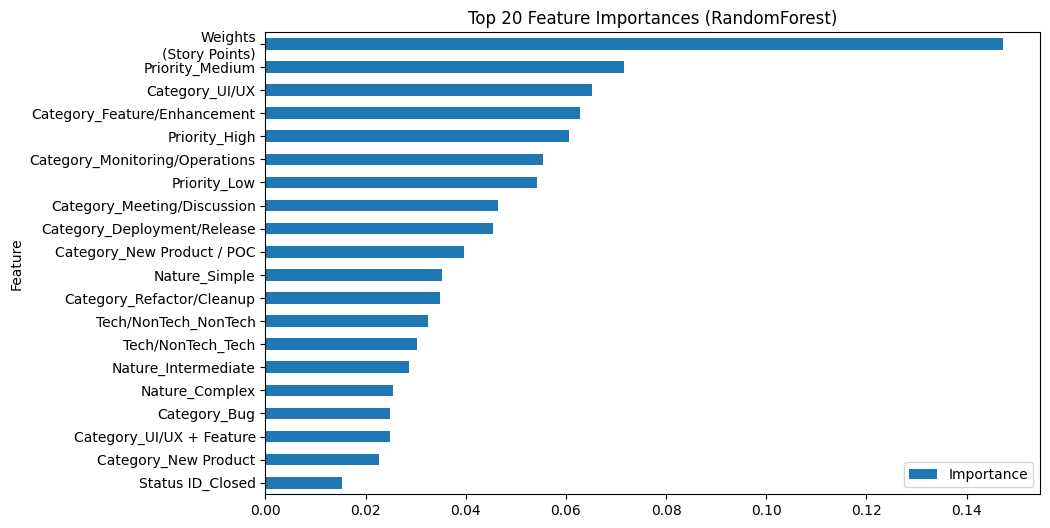

In [83]:
import matplotlib.pyplot as plt

feat_importances.head(20).plot(
    x="Feature", y="Importance", kind="barh", figsize=(10,6)
)
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()

In [85]:
# Sometimes it’s biased toward features with many categories.
# A more robust method is permutation importance:
# This checks how accuracy drops when a feature’s values are shuffled → better measure of real importance.

from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(perm_importances.head(15))


                            Feature  Importance
6                     Nature_Simple    0.020408
9       Category_Deployment/Release    0.018367
14   Category_Monitoring/Operations    0.008163
1       Project_MeriPehchaan (NSSO)    0.000000
8      Category_Configuration/Setup    0.000000
10           Category_Documentation    0.000000
3                 Tech/NonTech_Tech    0.000000
2              Tech/NonTech_NonTech    0.000000
13      Category_Meeting/Discussion    0.000000
12             Category_Integration    0.000000
15             Category_New Product    0.000000
22              Category_Testing/QA    0.000000
20           Category_Specification    0.000000
21  Category_Specification/Analysis    0.000000
17                   Category_Other    0.000000


In [77]:
# # --------------------
# # Function: Predict employee(s) for a new task
# # --------------------
# def predict_employee(new_task_dict, top_k=5):
#     """
#     new_task_dict: dict with same categorical keys as training data
#                    e.g. {
#                        "Project": "ABC",
#                        "Tech/NonTech": "Tech",
#                        "Nature": "Development",
#                        "Category": "Backend",
#                        "Priority": "High",
#                        "Status ID": "Open"
#                    }
#     top_k: how many best employees to return
#     """
#     # Convert new task into DataFrame
#     new_task_df = pd.DataFrame([new_task_dict])

#     # Apply same one-hot encoding as training
#     new_task_encoded = pd.get_dummies(new_task_df)

#     # Align with training columns (fill missing with 0)
#     new_task_encoded = new_task_encoded.reindex(columns=X.columns, fill_value=0)

#     # Predict probabilities
#     probs = clf.predict_proba(new_task_encoded)[0]

#     # Get top-k employees
#     topk_ids = np.argsort(probs)[-top_k:][::-1]
#     topk_employees = le.inverse_transform(topk_ids)
#     topk_scores = probs[topk_ids]

#     # Return as DataFrame for clarity
#     return pd.DataFrame({
#         "Employee": topk_employees,
#         "Confidence": topk_scores
#     })


# # --------------------
# # Example usage
# # --------------------
# new_task = {
#     "Project": "ABC",
#     "Tech/NonTech": "Tech",
#     "Nature": "Development",
#     "Category": "Backend",
#     "Priority": "High",
#     "Status ID": "Open"
# }

# print("\nPredicted best employees for the new task:")
# print(predict_employee(new_task, top_k=8))


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder

# --------------------
# Load data
# --------------------
sheet_id = "15hQxQCelrIhxrzfqXSa1mCM6suCt9E5Bf85LbqqizcA"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)
# --------------------
# Preprocessing
# --------------------
cat_cols = ["Project", "Tech/NonTech", "Nature", "Category", "Priority", "Status ID"]
df_encoded = pd.get_dummies(df, columns=cat_cols)

X = df_encoded.drop(columns=["Emp Name", "AID", "Task"])
y_raw = df["Emp Name"]

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# 🎯 Scale Category features to emphasize them
category_cols = [col for col in X.columns if col.startswith("Category")]
X[category_cols] = X[category_cols] * 10   ###################### <-- adjust multiplier here (3x weight)

# --------------------
# Handle singleton employees
# --------------------
emp_counts = y_raw.value_counts()
singletons = emp_counts[emp_counts == 1].index
mask_singletons = y_raw.isin(singletons)

X_train_main, X_test, y_train_main, y_test = train_test_split(
    X[~mask_singletons], y[~mask_singletons],
    test_size=0.2, random_state=42, stratify=y[~mask_singletons]
)

X_train = pd.concat([X_train_main, X[mask_singletons]])
y_train = np.concatenate([y_train_main, y[mask_singletons]])

# --------------------
# Train model
# --------------------
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

# --------------------
# Evaluation
# --------------------
y_pred = clf.predict(X_test)

# print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))
# print("Top-3 Accuracy:", top_k_accuracy_score(
#     y_test,
#     clf.predict_proba(X_test),
#     k=3,
#     labels=clf.classes_
# ))

# --------------------
# Function: Predict employee(s) for a new task
# --------------------
def predict_employee(new_task_dict, top_k=3):
    """
    Predict best matching employees for a new task.

    new_task_dict: dict with same categorical keys as training data
    top_k: number of top employees to return
    """
    # Convert dict to DataFrame
    new_task_df = pd.DataFrame([new_task_dict])

    # One-hot encode
    new_task_encoded = pd.get_dummies(new_task_df)

    # Align with training columns
    new_task_encoded = new_task_encoded.reindex(columns=X.columns, fill_value=0)

    # Predict probabilities
    probs = clf.predict_proba(new_task_encoded)[0]

    # Get top-k employees
    topk_ids = np.argsort(probs)[-top_k:][::-1]
    topk_employees = le.inverse_transform(topk_ids)
    topk_scores = probs[topk_ids]

    return pd.DataFrame({
        "Employee": topk_employees,
        "Confidence": topk_scores
    })

# --------------------
# Example usage
# --------------------

new_task2 = {
    "AID": "0001",
    "Task": "Configuring server portal",
    "Project": "Digilocker",
    "Tech/NonTech": "Non Tech",
    "Nature": "Intermediate",
    "Category": "Configuration/Setup",
    "Priority": "Medium",
    "Status ID": "Open"
}
new_task1 = {
    "AID": "0002",
    "Task": "Fixing bugs in website",
    "Project": "MeriPehchaan",
    "Tech/NonTech": "Tech",
    "Nature": "Complex",
    "Category": "Bug",
    "Priority": "High",
    "Status ID": "In Progress"
}


print("\nPredicted best employees for the new task:")
print(new_task1)
print(predict_employee(new_task1, top_k=5))   # you can change n here
print("\nPredicted best employees for the new task:")
print(new_task2)
print(predict_employee(new_task2, top_k=10))   # you can change n here



Predicted best employees for the new task:
{'AID': '0002', 'Task': 'Fixing bugs in website', 'Project': 'MeriPehchaan', 'Tech/NonTech': 'Tech', 'Nature': 'Complex', 'Category': 'Bug', 'Priority': 'High', 'Status ID': 'In Progress'}
         Employee  Confidence
0     Ashu Sharma    0.480336
1      Ajit kumar    0.163354
2  Shrikant Bache    0.105087
3  Amit Kumar Das    0.103523
4     Saket Soman    0.092510

Predicted best employees for the new task:
{'AID': '0001', 'Task': 'Configuring server portal', 'Project': 'Digilocker', 'Tech/NonTech': 'Non Tech', 'Nature': 'Intermediate', 'Category': 'Configuration/Setup', 'Priority': 'Medium', 'Status ID': 'Open'}
              Employee  Confidence
0          Ashu Sharma    0.334476
1           Ajit kumar    0.173038
2          Akash Dutta    0.156859
3       Shrikant Bache    0.117545
4       Amit Kumar Das    0.106999
5          Ankit kumar    0.039814
6   chandrakanta panda    0.033318
7        Hiranya Sarma    0.015234
8          Saket S

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Optional: install extra libs if not present
# !pip install xgboost lightgbm catboost

# --------------------
# Load data
# --------------------
sheet_id = "15hQxQCelrIhxrzfqXSa1mCM6suCt9E5Bf85LbqqizcA"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# --------------------
# Preprocessing
# --------------------
cat_cols = ["Project", "Tech/NonTech", "Nature", "Category", "Priority", "Status ID"]
df_encoded = pd.get_dummies(df, columns=cat_cols)

X = df_encoded.drop(columns=["Emp Name", "AID", "Task"])
y_raw = df["Emp Name"]

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Emphasize Category
category_cols = [col for col in X.columns if col.startswith("Category")]
X[category_cols] = X[category_cols] * 10

# Handle singleton employees
emp_counts = y_raw.value_counts()
singletons = emp_counts[emp_counts == 1].index
mask_singletons = y_raw.isin(singletons)

X_train_main, X_test, y_train_main, y_test = train_test_split(
    X[~mask_singletons], y[~mask_singletons],
    test_size=0.2, random_state=42, stratify=y[~mask_singletons]
)

X_train = pd.concat([X_train_main, X[mask_singletons]])
y_train = np.concatenate([y_train_main, y[mask_singletons]])

# --------------------
# Model Selector
# --------------------
def get_model(model_type="randomforest"):
    if model_type == "randomforest":
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
    elif model_type == "xgboost":
        from xgboost import XGBClassifier
        return XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
    elif model_type == "lightgbm":
        from lightgbm import LGBMClassifier
        return LGBMClassifier(n_estimators=300, random_state=42, class_weight="balanced")
    elif model_type == "catboost":
        from catboost import CatBoostClassifier
        return CatBoostClassifier(iterations=300, random_state=42, verbose=0, class_weights="Balanced")
    else:
        raise ValueError("Choose from: randomforest, xgboost, lightgbm, catboost")

# --------------------
# Train & Evaluate
# --------------------
model_type = "catboost"   # 🔄 change this to "randomforest", "xgboost", "lightgbm", "catboost"
clf = get_model(model_type)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"\n🔎 Model: {model_type}")
print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))
print("Top-3 Accuracy:", top_k_accuracy_score(
    y_test,
    clf.predict_proba(X_test),
    k=3,
    labels=clf.classes_
))

# --------------------
# Predict function
# --------------------
def predict_employee(new_task_dict, top_k=3):
    new_task_df = pd.DataFrame([new_task_dict])
    new_task_encoded = pd.get_dummies(new_task_df)
    new_task_encoded = new_task_encoded.reindex(columns=X.columns, fill_value=0)
    probs = clf.predict_proba(new_task_encoded)[0]
    topk_ids = np.argsort(probs)[-top_k:][::-1]
    topk_employees = le.inverse_transform(topk_ids)
    topk_scores = probs[topk_ids]
    return pd.DataFrame({"Employee": topk_employees, "Confidence": topk_scores})

# --------------------
# Example usage
# --------------------
new_task1 = {
    "Project": "MeriPehchaan",
    "Tech/NonTech": "Tech",
    "Nature": "Complex",
    "Category": "Bug",
    "Priority": "High",
    "Status ID": "In Progress"
}

print("\nPredicted employees for a new task:")
print(predict_employee(new_task1, top_k=5))
